# Image classification using a convolutional neural network (CNN) with the fastai library and images from Google


In [1]:
#Only CPU compute is used

#Import fastai (version 1.0)
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.widgets import *

np.random.seed(100)

#Name of categories
#Five different freshwater fish species
categories = ["tinca_tinca", "anguilla_anguilla", "esox_lucius", "perca_fluviatilis", "rutilus_rutilus"]

#Define working folder
working_folder = %pwd
working_folder = Path(working_folder)

## Get training data

Download images from https://duckduckgo.com/
Using the following JavaScript snippet:

*urls = Array.from(document.querySelectorAll('.tile--img__img')).map(el=> el.hasAttribute('data-src')? "https:"+el.getAttribute('data-src'):"https:"+el.getAttribute('src'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));*


* Enter search query in duckduckgo
* Scroll down past many images
* Execute snippet in console (right click webpage -> inspect -> console)
* Save downloaded file with image urls in working folder with name of category

In [21]:
#Get urls in .csv files, make dirs and download images
for i in categories:
    folder = i
    file = i+'.csv'
    dest = working_folder/i
    dest.mkdir(parents=True, exist_ok=True)
    download_images(working_folder/file, dest, max_pics=200)

In [22]:
#Verify images
for i in categories:
    print(i)
    verify_images(working_folder/i, delete=True, max_size=500)

tinca_tinca


anguilla_anguilla


esox_lucius


perca_fluviatilis


rutilus_rutilus


## Fit an initial CNN to clean raw image data
We will train an initial CNN on all the downloaded images. Using this model and the computed loss for each images, we will filter out nonsense images using a fastai widget.

In [2]:
#Define databunch, use all data as we are interested in filtering out nonsens images
rawdata = ImageDataBunch.from_folder(working_folder, train=".", valid_pct=0,
        ds_tfms=get_transforms(), bs = 32, size=224, num_workers=4).normalize(imagenet_stats)

(['anguilla_anguilla',
  'esox_lucius',
  'perca_fluviatilis',
  'rutilus_rutilus',
  'tinca_tinca'],
 5,
 1000,
 1)

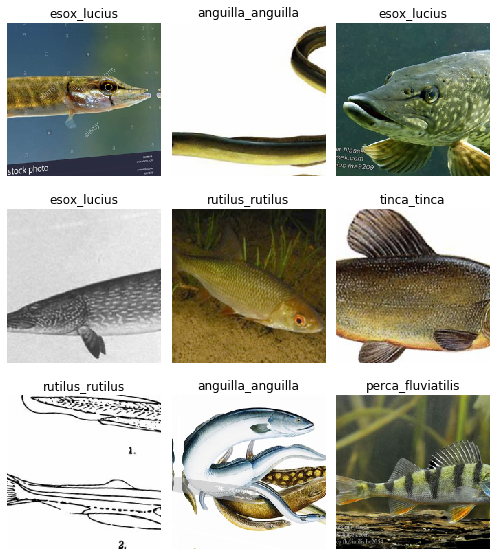

In [3]:
#Inspect rawdata and print attributes as a sanity check
rawdata.show_batch(rows=3, figsize=(7,8))
rawdata.classes, rawdata.c, len(rawdata.train_ds), len(rawdata.valid_ds)

In [4]:
#Define learner and fit 5 epochs
learn = cnn_learner(rawdata, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(5)

In [5]:
#Use image cleaner widget to delete or re-categorise images. Paths and labels of the "cleaned" dataset are available in the cleaned.csv file. 
ds, idxs = DatasetFormatter().from_toplosses(learn)
ImageCleaner(ds, idxs, working_folder)

'No images to show :)'

## Training a CNN on cleaned image data
We will fine-tune the last part/the head of an existing model (ResNet34) to classify the images.

We explore two approaches
* Regular training for a number of epochs
* Perform initial training with lower resolution images and re-use the learned weights to continue training with higher resolution images

The last approach (progressive resizing) should reduce the amount of time required to train the model and potentially its accuracy.

In [2]:
#Function return databunch from an input image size
def data_cleaned(image_size):
    data = ImageDataBunch.from_csv(working_folder, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
        ds_tfms=get_transforms(), size=image_size, num_workers=4, bs = 32).normalize(imagenet_stats)
    return(data)

(['anguilla_anguilla',
  'esox_lucius',
  'perca_fluviatilis',
  'rutilus_rutilus',
  'tinca_tinca'],
 5,
 664,
 166)

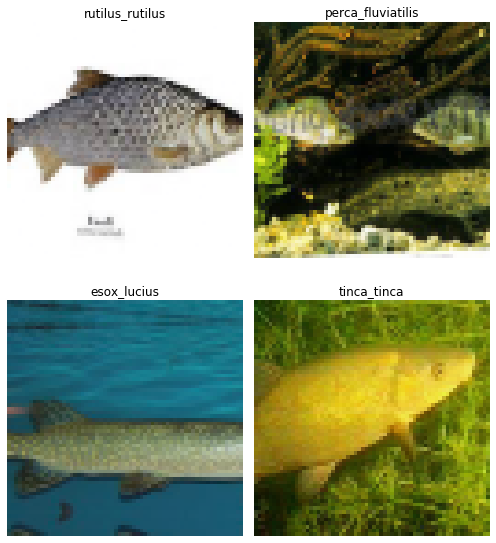

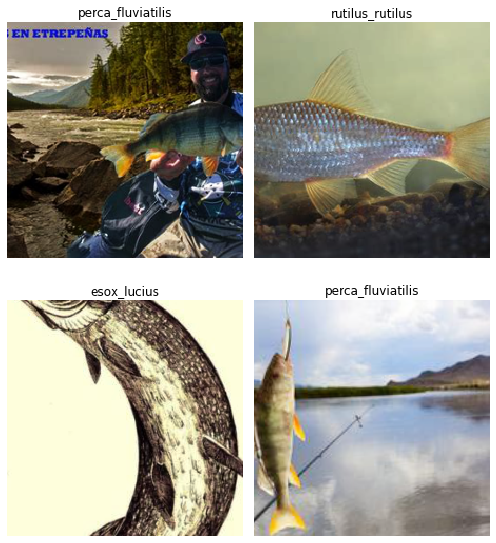

In [4]:
#Define data bunches with different resolution images
#View the data and attributes
data_cleaned_64 = data_cleaned(64)
data_cleaned_112 = data_cleaned(112)
data_cleaned_224 = data_cleaned(224)

#Show lower resolution image samples
data_cleaned_64.show_batch(rows=2, figsize=(7,8))
data_cleaned_224.show_batch(rows=2, figsize=(7,8))

data_cleaned_224.classes, data_cleaned_224.c, len(data_cleaned_224.train_ds), len(data_cleaned_224.valid_ds)

### CNN *without* resizing

Regular training network on "high" resolution images. Further improvement could maybe be obtained by searching for more appropriate learning rates.

In [5]:
learn_without = cnn_learner(data_cleaned_224, models.resnet34, metrics=error_rate)
learn_without.fit_one_cycle(6) #~02:30 per epoch, aac. 0.036

epoch,train_loss,valid_loss,error_rate,time
0,1.901073,0.391853,0.114458,02:32
1,0.998402,0.289696,0.072289,02:28
2,0.676929,0.183326,0.054217,02:39
3,0.502365,0.186777,0.042169,02:22
4,0.383194,0.173594,0.036145,02:31
5,0.312523,0.172110,0.036145,02:35


### CNN *with* resizing

We train the last part of the network on small images, then use these weights to train on medium images and finally use the medium resolution weights to train network on high resolution images

In [49]:
learn_low = cnn_learner(data_cleaned_64, models.resnet34, metrics=error_rate)
learn_low.fit_one_cycle(2)
learn_low.save("low") #~00:30 per epoch

epoch,train_loss,valid_loss,error_rate,time
0,2.300871,1.611023,0.469880,00:30
1,1.850794,1.563655,0.445783,00:32


In [50]:
learn_med = cnn_learner(data_cleaned_112, models.resnet34, metrics=error_rate).load("low")
learn_med.fit_one_cycle(2)
learn_med.save("med") #~01:00 per epoch

epoch,train_loss,valid_loss,error_rate,time
0,1.265458,0.718191,0.246988,01:08
1,1.005154,0.645896,0.198795,01:07


In [55]:
learn_high = cnn_learner(data_cleaned_224, models.resnet34, metrics=error_rate).load("med")
learn_high.fit_one_cycle(2)
learn_high.save("high") #~02:30 per epoch

epoch,train_loss,valid_loss,error_rate,time
0,0.611466,0.181274,0.048193,02:40
1,0.428635,0.190365,0.054217,02:43


### Using the model
Use the model to label new images

In [54]:
new_image = open_image(working_folder/'pike_small.jpg')
pred_class, pred_idx, outputs = learn_high.predict(new_image)
print("%.3f probability of %s" % (outputs[pred_idx], pred_class))

0.984 probability of esox_lucius


### Conclusions

* Accurate classification models can be built rapidly using the fastai library with images downloaded from Google.
* While the quality of the images are not consistent, we can use an initial network to guide the process of filtering bad images.
* Progressive resizing can reduce the time spent fine-tuning the network. 